In [1]:
import shapely.geometry
import fiona
from sklearn.cluster import KMeans
import pandas as pd
from fiona import collection
from collections import OrderedDict

In [2]:
with fiona.open('./forest/TRI_Cell.shp', 'r') as source:
    # store info about the file
    source_driver = source.driver
    source_crs = source.crs
    source_schema = source.schema
    
    tree = []
    
    for f in source:
        # loop through polygons and get the relevant information we want
        
        # skip invalid geometries
        if len(f['geometry']['coordinates'][0]) < 3:
            # print('err')
            continue
        
        # get tree type
        treeType = f['properties']['ECOCLASS']
        
        # get centroid coordinates
        pol = shapely.geometry.Polygon(f['geometry']['coordinates'][0])
        xcoord = list(pol.centroid.coords)[0][0]
        ycoord = list(pol.centroid.coords)[0][1]
        
        # write the data
        tree.append((xcoord, ycoord, treeType))       
    

In [3]:
cent = pd.DataFrame(tree, columns = ['xcoord', 'ycoord', 'treeType'])
cent.head()

xcoord        ycoord treeType
0  383365.617607  1.527850e+06       CH
1  375674.234310  1.528075e+06       CH
2  374704.076275  1.528200e+06       CH
3  376316.566648  1.528263e+06       CH
4  372623.794223  1.527191e+06       CF

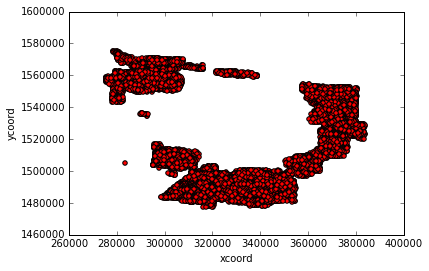

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
cent.plot.scatter(x = 'xcoord', y = 'ycoord', c='red')

In [14]:
# Should I do supervised or unsupervised?
# train_test_split would be necessary for supervised
km = KMeans(n_clusters = 7, n_init = 10)
km.fit(cent[['xcoord', 'ycoord']])
y_pred = km.predict(cent[['xcoord', 'ycoord']])

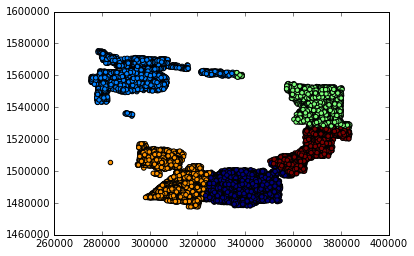

In [15]:
#plt.figure()
plt.scatter(cent['xcoord'], cent['ycoord'], c = y_pred)

In [8]:
# add the y_pred to the cent df

cent['clusterID'] = y_pred
cent.head()

xcoord        ycoord treeType  clusterID
0  383365.617607  1.527850e+06       CH          5
1  375674.234310  1.528075e+06       CH          5
2  374704.076275  1.528200e+06       CH          5
3  376316.566648  1.528263e+06       CH          5
4  372623.794223  1.527191e+06       CF          5

In [11]:
new_schema = {'geometry': 'Point',
             'properties': OrderedDict([('ECOCLASS', 'str:5'), ('clusterID', 'int:1')])}

In [13]:
# write a shapefile with these new schema additions
with fiona.open(
        './clustered_forest/clustered_forest.shp',
        'w',
        driver = source_driver,
        crs = source_crs,
        schema = new_schema) as dest:
    for index, row in cent.iterrows():
        point = shapely.geometry.Point(row['xcoord'], row['ycoord'])
        dest.write({
                'geometry': shapely.geometry.mapping(point),
                'properties': {'ECOCLASS': '{}'.format(row['treeType']),
                              'clusterID': '{}'.format(row['clusterID'])}
            })